<a href="https://colab.research.google.com/github/nohjuhyeon/study_AIs/blob/main/docs/quests/NLPs/classification_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 사용할 pickle 불러오기
- sentence_tokenizing : 문장 토큰화 모델
- classification_topic : 토픽 분류 모델

In [237]:
file_path = 'NLP_classification_ynanaewstitles.pkl'
import pickle
with open(file_path,'rb') as pickle_file:
  classification_topic = pickle.load(pickle_file)


In [236]:
# pickle 불러오기
file_path = 'sentence_tokenizing.pkl'
import pickle
with open(file_path,'rb') as pickle_file:
  sentence_tokenizing = pickle.load(pickle_file)


## 한글처리

In [217]:
!apt-get -y install fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [218]:
!ls /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf

/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf


## 사용할 데이터 불러오기 및 전처리

In [241]:
# 파일 불러오기
import pandas as pd
df_IT_news = pd.read_excel('IT News.xlsx', sheet_name = None)
topic = pd.read_csv("topic_dict.csv")
len(df_IT_news)

45

In [367]:
df_sheets = []
for sheet_name, df in df_IT_news.items():
  df = df[df['문장 요약'].notnull()]
  if df.columns[0] != "이름":
    print(df.columns[0])
    df = df.rename(columns={df.columns[0]: '이름'})
  df.reset_index(inplace = True)
  df_sheets.append(df)
df_sheets[4]

ㅋ
ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
ㅋㅋㅋㅋㅋㅋㅋ
ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
ㅋ


,index,이름,선호도 투표,뉴스명,문장 요약,한 줄평
0,1,김유진,NaN,"브이캣, SSG닷컴에 ‘영상 및 배너 제작 AI 솔루션’ 공급",브이캣은 SSG닷컴에 상품의 URL만 입력하면 영상과 배너를 만들 수 있는 시스템을...,"특히 빠른 교체가 중요한 기획전, 이벤트 영역의 배너 전량이 자동 제작되도록 SSG..."
1,4,박요한,NaN,"“지수까지 나올 줄이야” 스마일게이트, 첫 투자 영화 ‘전독시’ 본격 촬영",게임 회사 스마일게이트의 ‘외도’가 주목을 끈다. 처음으로 게임이 아닌 영화 투자·...,하나의 분야에서만 활동하던 기업들이 다방면으로 넓게 시야를 넓히고 있는 것은 하나의...
2,6,김명준,NaN,97% 정확도...피만 뽑으면 알츠하이머인지 알 수 있다,알츠하이머 유발 단백질 ‘타우’\n97% 높은 정확도로 감지 가능\n조기 진단·치료...,"현재의 진단시스템은 검사 비용이 높고 진단 기간도 길다는 단점이 있는 반면 만약, ..."
3,9,조유경,NaN,[단독] 아내에게 전화했는데 다른 사람 목소리가…KT는 “껐다 켜라”,전화를 걸었을때 실제 전화를 건 연락처가 아닌 다른 연락처로 전화가 연결되는 이슈가...,현재 원인을 파악하고 있으나 아직까지 파악하지 못하였다. 이 상황이 범죄에 악용된다...


## 문장 토큰화하기

In [373]:
! pip install konlpy

In [374]:
from konlpy.tag import Okt
okt = Okt()

In [375]:
# 형태소 분석 함수
def okt_clean(text):
    clean_text = []
    for word in okt.pos(text, stem=True):
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']:
            clean_text.append(word[0])

    return " ".join(clean_text)

In [376]:
# 문장 토큰화 함수
def sentence_token(x,okt_clean,sentence_tokenizing):
  sentence_nouns = okt_clean(x)
  sentence_tokens = sentence_tokenizing.transform([sentence_nouns])
  return sentence_tokens.toarray()

In [377]:
# topic 리스트 만드는 함수
def topic_list_make(df_sheets,sentence_token,condition_list):
  sentence_list = []
  for i in range(len(df_sheets)):
    column_name = df_sheets[i].columns[1]
    condition_list = condition_list
    condition = f"{column_name} in {condition_list}"
    for j in range(len(df_sheets[i].query(condition)['문장 요약'].values)):
      sentence_tokens_array = sentence_token(df_sheets[i].query(condition)['문장 요약'].values[j],okt_clean,sentence_tokenizing)
      topic_index=int(classification_topic.predict(sentence_tokens_array)[0])
      sentence_list.append(topic.iloc[topic_index,0])
  Series_topic = pd.Series(data=sentence_list)
  topic_list = Series_topic.value_counts()
  return topic_list

In [428]:
user_list = ["노주현"]
user_topic_list = topic_list_make(df_sheets,sentence_token,user_list)
user_topic_list

IT과학    17
사회       2
경제       1
세계       1
정치       1
dtype: int64

In [411]:
entire_user_list = list(df_sheets[0]["이름"].values)

entire_topic_list = topic_list_make(df_sheets,sentence_token,entire_user_list)
entire_topic_list

IT과학    184
경제       27
사회       27
정치       10
세계        8
생활문화      3
스포츠       1
dtype: int64

## Wordcloud

### user wordcloud

In [412]:
from wordcloud import WordCloud

In [429]:
wordCloud = WordCloud(background_color='white', font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
user_wordcloud = wordCloud.generate_from_frequencies(user_topic_list)
user_wordcloud

In [430]:
user_wordcloud.words_

{'IT과학': 1.0,
 '사회': 0.11764705882352941,
 '경제': 0.058823529411764705,
 '세계': 0.058823529411764705,
 '정치': 0.058823529411764705}

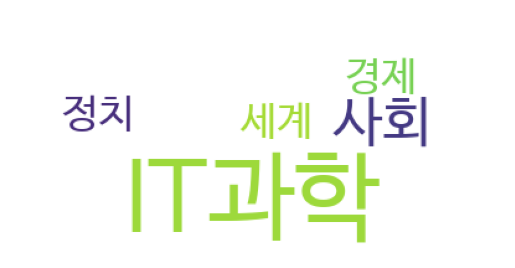

In [431]:
import matplotlib.pyplot as plt
plt.imshow(user_wordcloud)
plt.axis('off')
plt.show()

### entire wordcloud

In [402]:
from wordcloud import WordCloud

In [403]:
wordCloud = WordCloud(background_color='white', font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
user_wordcloud = wordCloud.generate_from_frequencies(entire_topic_list)
user_wordcloud

In [404]:
user_wordcloud.words_

{'IT과학': 1.0,
 '경제': 0.14673913043478262,
 '사회': 0.14673913043478262,
 '정치': 0.05434782608695652,
 '세계': 0.043478260869565216,
 '생활문화': 0.016304347826086956,
 '스포츠': 0.005434782608695652}

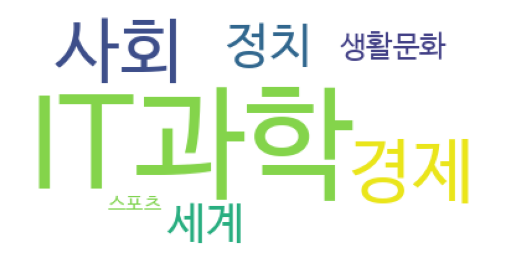

In [405]:
import matplotlib.pyplot as plt
plt.imshow(user_wordcloud)
plt.axis('off')
plt.show()